## Classification

In this last part of the lab, you will practice model evaluation and selection on a classification task. The process will be similar, with the main difference being the computation of the errors. You will see that in the following sections.

In [6]:
# for array computations and loading data
import numpy as np

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for graphing and visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# for building an training neural networks
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# reduce display precision on numpy arrays
np.set_printoptions(precision = 2)

# surpress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

### Load the Dataset

First, you will load a dataset for a binary classification task. It has 200 examples of two input features (`x1` and `x2`), and a target `y` of either `0` or `1`.

In [12]:
# Load the dataset from a text file
data = np.loadtxt('./logistic.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


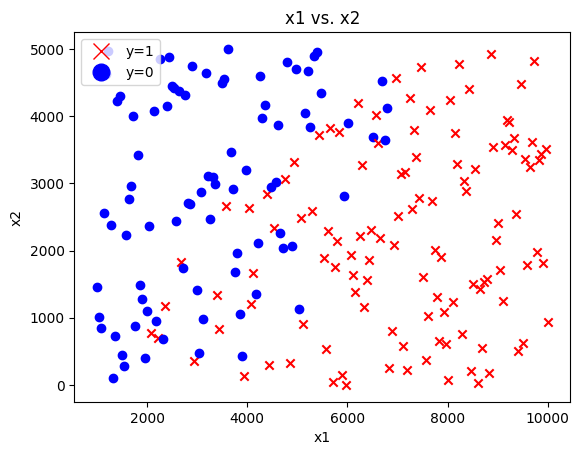

In [14]:
for i in range(len(y_bc)):
    marker = 'x' if y_bc[i] == 1 else 'o'
    c = 'r' if y_bc[i] == 1 else 'b'
    plt.scatter(x_bc[i,0], x_bc[i,1], marker=marker, c=c); 
plt.title("x1 vs x2")
plt.xlabel("x1"); 
plt.ylabel("x2"); 
y_0 = mlines.Line2D([], [], color='r', marker='x', markersize=12, linestyle='None', label='y=1')
y_1 = mlines.Line2D([], [], color='b', marker='o', markersize=12, linestyle='None', label='y=0')
plt.title("x1 vs. x2")
plt.legend(handles=[y_0, y_1])
plt.show()

In [16]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


In [17]:
# Scale the features

# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

### Evaluating the error for classification models

In the previous sections on regression models, you used the mean squared error to measure how well your model is doing. For classification, you can get a similar metric by getting the fraction of the data that the model has misclassified. For example, if your model made wrong predictions for 2 samples out of 5, then you will report an error of `40%` or `0.4`. 

The code below demonstrates this using a for-loop and also with Numpy's [`mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) function. THIS CODE IS JUST AN EXAMPLE

In [18]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


### Build and train the model

You will use the same neural network architectures in the previous section so you can call the `build_models()` function again to create new instances of these models. 

You will follow the recommended approach mentioned last week where you use a `linear` activation for the output layer (instead of `sigmoid`) then set `from_logits=True` when declaring the loss function of the model. You will use the [binary crossentropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) because this is a binary classification problem.

After training, you will use a [sigmoid function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid) to convert the model outputs into probabilities. From there, you can set a threshold and get the fraction of misclassified examples from the training and cross validation sets.

To check threshold, you can use np.where(yhat >= threshold, 1, 0). This checks if yhat is greater than or equal to the threshold and outputs 1 if true and 0 if false.

You can see all these in the code cell below.

In [20]:
# Build the models
tf.random.set_seed(20)

model_1 = Sequential(
    [
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(1, activation = 'linear')
    ],
    name='model_1'
)

model_2 = Sequential(
    [
        Dense(20, activation = 'relu'),
        Dense(12, activation = 'relu'),
        Dense(12, activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(1, activation = 'linear')
    ],
    name='model_2'
)

model_3 = Sequential(
    [
        Dense(32, activation = 'relu'),
        Dense(16, activation = 'relu'),
        Dense(8, activation = 'relu'),
        Dense(4, activation = 'relu'),
        Dense(12, activation = 'relu'),
        Dense(1, activation = 'linear')
    ],
    name='model_3'
)

models_bc = [model_1, model_2, model_3]

In [21]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train_scaled, y_bc_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")

    # Set the threshold for classification
    threshold = 0.5

    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(cv_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
    )

Training model_1...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training model_2...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training model_3...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 1: Training Set Classification Error: 0.05000, CV Set Classification Error: 0.15000
Model 2: Training Set Classification Error: 0.02500, CV Set Classification Error: 0.15000
Model 3: Training Set Classification Error: 0.10833, CV Set Classification Error: 0.17500


From the output above, you can choose which one performed best. If there is a tie on the cross validation set error, then you can add another criteria to break it. For example, you can choose the one with a lower training error. A more common approach is to choose the smaller model because it saves computational resources. In our example, Model 1 is the smallest and Model 3 is the largest.

Finally, you can compute the test error to report the model's generalization error.

In [22]:
# Select the model with the lowest error
model_num = 3

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Selected Model: 3
Training Set Classification Error: 0.1083
CV Set Classification Error: 0.1750
Test Set Classification Error: 0.1750
